In [1]:
import pandas
import numpy
from numpy import std, correlate, sqrt
from scipy.stats import pearsonr
import statsmodels.api as sm
from statsmodels.stats.mediation import Mediation
from linearmodels import IV2SLS
%run Table_Summary.ipynb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
plt.style.use('seaborn-whitegrid')
from math import pi
import openpyxl

# Data

In [42]:
filepath = 'G:/My Drive/Elio/Attention/Data/Original_data.txt'
data = pandas.read_csv(filepath,sep='\t')
data.rename(columns={'origi':'Id'},inplace=True)
print(data.shape,'from 2019_05_25_Results.xlxs')
print(data.Year.unique(),'Years')
print(data.Id.nunique(),'Number of firms')
filepath = 'G:/My Drive/Elio/Attention/Data/Database_secondreviewJIBS.dta'
data1 = pandas.read_stata(filepath)
data1.rename(columns={'id':'Id','year':'Year','country':'Country'},inplace=True)
data1 = data1[['Id','Year','Country']]
data1['Year'] = pandas.to_numeric(data1.Year.astype(str).str[0:4])
print(data1.shape,'to get country')
data = pandas.merge(left=data,right=data1,how='left',on=['Year','Id'])
print(data.Country.unique())
filepath = 'G:/My Drive/Elio/Attention/Data/2019_05_25_Results_updated.txt'
data2 = pandas.read_csv(filepath,sep='\t')
print(data2.shape,'correction by Elio of market commonality')
data2.rename(columns={'origi':'Id'},inplace=True)
data2 = data2[['Id','Year','Market_commonality']]
data.drop('Market_commonality',axis=1,inplace = True)
data = pandas.merge(left=data,right=data2,how='inner',on=['Year','Id'])
print(data.Non_RD_alliances.sum(),'Total number of Non-RD alliances')
print(data.RD_alliances.sum(),'Total number of RD alliances (hybrid alliances)')
filepath = 'G:/My Drive/Elio/Attention/Data/Count/Data/count_sim.txt'
data3 = pandas.read_csv(filepath,sep='\t')
data3['SUM'] = data3['geographic']+data3['growth']+data3['product']
data3['GEOGRAPHY0'] = data3.geographic/data3.SUM
data3['GROWTH0'] = data3.growth/data3.SUM
data3['PRODUCT0'] = data3['product']/data3.SUM
data3 = data3[['Id','GEOGRAPHY0','GROWTH0','PRODUCT0']]
data = pandas.merge(left=data,right=data3,how='inner',on=['Id'])
filepath = 'G:/My Drive/Elio/Attention/Data/Results_def_01_for_Elio.txt'
data4 = pandas.read_csv(filepath,sep='\t')
data4 = data4.iloc[1:1008,[0,1,25,26,27]]
data4.columns = ['Year','Id','PRODUCT','GEOGRAPHY','GROWTH']
data4['Year'] = pandas.to_numeric(data4.Year.astype(str).str[0:4])
print(data4)
data = pandas.merge(left=data,right=data4,how='inner',on=['Year','Id'])
print(data.columns)
data

(1232, 33) from 2019_05_25_Results.xlxs
[1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012] Years
56 Number of firms
(1539, 3) to get country
[nan 'USA' 'Switzerland' 'Netherlands' 'Germany' 'South Africa' 'Japan'
 'United Kingdom' 'France' 'Australia' 'Ireland' 'Spain' 'Denmark'
 'Sweden']
(1232, 34) correction by Elio of market commonality
4089.0 Total number of Non-RD alliances
7676.0 Total number of RD alliances (hybrid alliances)
      Year  Id  PRODUCT  GEOGRAPHY    GROWTH
1     1995   2     0.00   0.339996  0.660004
2     1995   3      NaN        NaN       NaN
3     1995   4      NaN        NaN       NaN
4     1995   5      NaN        NaN       NaN
5     1995   6      NaN        NaN       NaN
...    ...  ..      ...        ...       ...
1003  2012  52     0.75   0.075352  0.170363
1004  2012  53     0.83   0.000000  0.167799
1005  2012  54     0.00   0.997644  0.002356
1006  2012  55      NaN        NaN       NaN
1007 

,Id,Year,Age,Employees,Total_assets,Net_sales,Human_resources_1,Human_resources_2,Physical_resources_1,Physical_resources_2,...,ROA,ROE,Country,Market_commonality,GEOGRAPHY0,GROWTH0,PRODUCT0,PRODUCT,GEOGRAPHY,GROWTH
0,1,1996,94.0,74289.0,13364.000,14236.000,0.192,5.218,4844.000,0.340,...,0.114,0.243,USA,0.524,0.183858,0.241124,0.575019,0.0,0.784127,0.215873
1,1,1997,95.0,75639.0,13238.000,15070.000,0.199,5.019,5034.000,0.334,...,0.160,0.358,USA,0.237,0.183858,0.241124,0.575019,0.0,0.774649,0.225351
2,1,1998,96.0,73564.0,14153.000,15021.000,0.204,4.897,5566.000,0.371,...,0.083,0.198,USA,0.360,0.183858,0.241124,0.575019,0.0,0.750883,0.249117
3,1,1999,97.0,70549.0,13896.000,15659.000,0.222,4.505,5656.000,0.361,...,0.127,0.280,USA,0.323,0.183858,0.241124,0.575019,0.0,0.793790,0.206210
4,1,2000,98.0,75000.0,14522.000,16724.000,0.223,4.485,5823.000,0.348,...,0.123,0.273,USA,0.240,0.183858,0.241124,0.575019,0.0,0.788899,0.211101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,56,2008,148.0,47426.0,44031.724,22833.908,0.481,2.077,11198.211,0.490,...,0.100,0.230,Denmark,0.555,0.237752,0.190167,0.572081,NaN,NaN,NaN
1003,56,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Denmark,NaN,0.237752,0.190167,0.572081,NaN,NaN,NaN
1004,56,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Denmark,NaN,0.237752,0.190167,0.572081,NaN,NaN,NaN
1005,56,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Denmark,NaN,0.237752,0.190167,0.572081,NaN,NaN,NaN


# Variables

In [94]:
df = data.copy()
df = df.sort_values(by=['Id','Year'],axis=0,ascending=True)

# AMBIDEXTROUS ALLIANCES
print(df.Non_RD_alliances.corr(df.RD_alliances),'correlation between RD alliances and non-RD alliances')
df['Ambidextrous alliances'] = (1/1000)*df.RD_alliances*df.Non_RD_alliances

# UNDERPERFORMANCE MAGNITUDE
df['distance'] = df['ROE'] - df.groupby(['Year']).ROE.transform('mean')
df.loc[(df.distance<0),'Underperformance magnitude']=df['distance']
df.loc[(df.distance>0)|(df.distance==0),'Underperformance magnitude']=0
print(df['Underperformance magnitude'].quantile(0.5))

# UNDERPERFORMANCE DURATION
df['Underperformance duration'] = 0
mylist = []
for firm in range(df.Id.nunique()):
  mylist.append(df.loc[df.Id==firm+1,['Id','Year','Underperformance magnitude','Underperformance duration']].values.tolist())
m = [[0,0,0]]
for firm in range(df.Id.nunique()):
  for i in mylist[firm]: 
    if i[2]<0:
      m.append([i[0],i[1],m[-1][2]+1])
    else:
      m.append([i[0],i[1],i[3]])
del m[0]
mydf = pandas.DataFrame(m,columns=['Id','Year','Underperformance duration'])
df = df.drop('Underperformance duration',axis=1)
df = pandas.merge(left=df,right=mydf,how='inner',on=['Year','Id'])
df = df.sort_values(by=['Id','Year'], axis=0, ascending=True)
print(df['Underperformance duration'].quantile(0.1))

# 4 DUMMIES
df[''] = 0
df['High magnitude and High duration'] = 0
df.loc[(df['Underperformance magnitude']<df['Underperformance magnitude'].quantile(0.5))&
       (df['Underperformance duration']>df['Underperformance duration'].quantile(0.65)),
       'High magnitude and High duration'] = 1
print(df['High magnitude and High duration'].value_counts())

df['High magnitude and Low duration'] = 0
df.loc[(df['Underperformance magnitude']<df['Underperformance magnitude'].quantile(0.5))&
       (df['Underperformance duration']<df['Underperformance duration'].quantile(0.65)),
       'High magnitude and Low duration'] = 1
print(df['High magnitude and Low duration'].value_counts())

df['Low magnitude and High duration'] = 0
df.loc[(df['Underperformance magnitude']>df['Underperformance magnitude'].quantile(0.5))&
       (df['Underperformance duration']>df['Underperformance duration'].quantile(0.65)),
       'Low magnitude and High duration'] = 1
print(df['Low magnitude and High duration'].value_counts())

df['Low magnitude and Low duration'] = 0
df.loc[(df['Underperformance magnitude']>df['Underperformance magnitude'].quantile(0.5))&
       (df['Underperformance duration']<df['Underperformance duration'].quantile(0.65)),
       'Low magnitude and Low duration'] = 1
print(df['Low magnitude and Low duration'].value_counts())

# ATTENTIONAL FOCUS
df['Attentional focus'] = df[['PRODUCT','GEOGRAPHY','GROWTH']].apply(lambda x: x.std(skipna=True), axis=1)

# CONTROL VARIABLES
df['distance'] = df['ROE'] - df.groupby(['Year']).ROE.transform('mean')
df.loc[(df.distance>0)|(df.distance==0),'Overperformance magnitude']=df['distance']
df.loc[(df.distance<0)|(df.distance==0),'Overperformance magnitude']=0

df['Overperformance duration'] = 0
mylist = []
for firm in range(df.Id.nunique()):
  mylist.append(df.loc[df.Id==firm+1,['Id','Year','Overperformance magnitude','Overperformance duration']].values.tolist())
m = [[0,0,0]]
for firm in range(df.Id.nunique()):
  for i in mylist[firm]: 
    if i[2]>0:
      m.append([i[0],i[1],m[-1][2]+1])
    else:
      m.append([i[0],i[1],i[3]])
del m[0]
print(m)
print(len(m))
mydf = pandas.DataFrame(m,columns=['Id','Year','Overperformance duration'])
df = df.drop('Overperformance duration',axis=1)
df = pandas.merge(left=df,right=mydf,how='inner',on=['Year','Id'])
print(df.loc[(df.Id==38)|(df.Id==39),['Id','Year','Overperformance magnitude','Overperformance duration']])
df = df.sort_values(by=['Id','Year'], axis=0, ascending=True)

df['Absorbed slack'] = df['Absorbed_slack']
df['Unabsorbed slack'] = df['Unabsorbed_slack']
df['Absorptive capacity'] = df['Absorptive_capacity']
df['Market commonality'] = df['Market_commonality']
df['Size'] = numpy.log(df.Employees) 

df

0.7259338699988971 correlation between RD alliances and non-RD alliances
-0.03221296296296295
0.0
0    710
1    297
Name: High magnitude and High duration, dtype: int64
0    909
1     98
Name: High magnitude and Low duration, dtype: int64
0    980
1     27
Name: Low magnitude and High duration, dtype: int64
0    596
1    411
Name: Low magnitude and Low duration, dtype: int64
[[1.0, 1996.0, 1], [1.0, 1997.0, 2], [1.0, 1998.0, 0.0], [1.0, 1999.0, 1.0], [1.0, 2000.0, 2.0], [1.0, 2001.0, 3.0], [1.0, 2002.0, 4.0], [1.0, 2003.0, 5.0], [1.0, 2004.0, 6.0], [1.0, 2005.0, 7.0], [1.0, 2006.0, 8.0], [1.0, 2007.0, 9.0], [1.0, 2008.0, 10.0], [1.0, 2009.0, 11.0], [1.0, 2010.0, 12.0], [1.0, 2011.0, 13.0], [1.0, 2012.0, 14.0], [2.0, 1995.0, 15.0], [2.0, 1996.0, 16.0], [2.0, 1997.0, 17.0], [2.0, 1998.0, 18.0], [2.0, 1999.0, 19.0], [2.0, 2000.0, 20.0], [2.0, 2001.0, 0.0], [2.0, 2002.0, 1.0], [2.0, 2003.0, 2.0], [2.0, 2004.0, 3.0], [2.0, 2005.0, 0.0], [2.0, 2006.0, 0.0], [2.0, 2007.0, 0.0], [2.0, 2008.0, 

,Id,Year,Age,Employees,Total_assets,Net_sales,Human_resources_1,Human_resources_2,Physical_resources_1,Physical_resources_2,...,Low magnitude and High duration,Low magnitude and Low duration,Attentional focus,Overperformance magnitude,Overperformance duration,Absorbed slack,Unabsorbed slack,Absorptive capacity,Market commonality,Size
0,1,1996,94.0,74289.0,13364.000,14236.000,0.192,5.218,4844.000,0.340,...,0,1,0.405045,0.049000,1.0,0.256,0.196,0.067,0.524,11.215718
1,1,1997,95.0,75639.0,13238.000,15070.000,0.199,5.019,5034.000,0.334,...,0,1,0.398454,0.228423,2.0,0.253,0.120,0.066,0.237,11.233727
2,1,1998,96.0,73564.0,14153.000,15021.000,0.204,4.897,5566.000,0.371,...,0,0,0.382460,0.000000,0.0,0.252,0.121,0.068,0.360,11.205911
3,1,1999,97.0,70549.0,13896.000,15659.000,0.222,4.505,5656.000,0.361,...,0,1,0.411881,0.092415,1.0,0.252,0.115,0.066,0.323,11.164063
4,1,2000,98.0,75000.0,14522.000,16724.000,0.223,4.485,5823.000,0.348,...,0,1,0.408407,0.115167,2.0,0.328,0.635,0.066,0.240,11.225243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,56,2008,148.0,47426.0,44031.724,22833.908,0.481,2.077,11198.211,0.490,...,0,1,NaN,0.037640,1.0,0.433,2.123,0.148,0.555,10.766926
1003,56,2009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1004,56,2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1005,56,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


In [95]:
dv = ['Ambidextrous alliances']
iv = ['High magnitude and High duration',
      'High magnitude and Low duration',
      'Low magnitude and High duration',
      'Low magnitude and Low duration',
      'Attentional focus','Overperformance magnitude','Overperformance duration','Absorbed slack','Unabsorbed slack','Absorptive capacity','Market commonality','Size']
mydata = df[dv+iv]
mydata

,Ambidextrous alliances,High magnitude and High duration,High magnitude and Low duration,Low magnitude and High duration,Low magnitude and Low duration,Attentional focus,Overperformance magnitude,Overperformance duration,Absorbed slack,Unabsorbed slack,Absorptive capacity,Market commonality,Size
0,0.000,0,0,0,1,0.405045,0.049000,1.0,0.256,0.196,0.067,0.524,11.215718
1,0.000,0,0,0,1,0.398454,0.228423,2.0,0.253,0.120,0.066,0.237,11.233727
2,0.002,0,1,0,0,0.382460,0.000000,0.0,0.252,0.121,0.068,0.360,11.205911
3,0.000,0,0,0,1,0.411881,0.092415,1.0,0.252,0.115,0.066,0.323,11.164063
4,0.000,0,0,0,1,0.408407,0.115167,2.0,0.328,0.635,0.066,0.240,11.225243
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,0.004,0,0,0,1,NaN,0.037640,1.0,0.433,2.123,0.148,0.555,10.766926
1003,0.012,0,0,0,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1004,NaN,0,0,0,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1005,NaN,0,0,0,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


# Table 2

In [96]:
ds_mean = mydata.agg(['mean','std','count']).T
corr = mydata.corr()
corr = pandas.concat([ds_mean,corr], axis = 1)
corr = corr.applymap('{:.3f}'.format)
corr['statistics'] = ' '
corr.set_index('statistics',append=True,inplace=True)

def pearsonr_pval(x,y):
  return pearsonr(x,y)[1].round(3)
pval = mydata.corr(method=pearsonr_pval)
pval = pval.applymap('{:.3f}'.format)
pval = pval.applymap(lambda x: '(' + x + ')')
pval['statistics'] = 'p-value'
pval.set_index('statistics',append=True,inplace=True)

corr = pandas.concat([corr,pval],axis=0).sort_index(kind='merge').reindex(dv+iv,axis=0,level=0)
corr.to_excel('Table2.xlsx')
corr

mean     std     count  \
                                 statistics                            
Ambidextrous alliances                       0.056   0.128   794.000   
                                 p-value       NaN     NaN       NaN   
High magnitude and High duration             0.295   0.456  1007.000   
                                 p-value       NaN     NaN       NaN   
High magnitude and Low duration              0.097   0.297  1007.000   
                                 p-value       NaN     NaN       NaN   
Low magnitude and High duration              0.027   0.162  1007.000   
                                 p-value       NaN     NaN       NaN   
Low magnitude and Low duration               0.408   0.492  1007.000   
                                 p-value       NaN     NaN       NaN   
Attentional focus                            0.461   0.102   536.000   
                                 p-value       NaN     NaN       NaN   
Overperformance magnitude                    0.098   0.333   904.000   
                                 p-value       NaN     NaN       NaN   
Overperformance duration                     1.741   3.548  1007.000   
                                 p-value       NaN     NaN       NaN   
Absorbed slack                               1.966  37.881   679.000   
                                 p-value       NaN     NaN       NaN   
Unabsorbed slack                             1.391   1.988   724.000   
                                 p-value       NaN     NaN       NaN   
Absorptive capacity                          0.233   0.723   899.000   
                                 p-value       NaN     NaN       NaN   
Market commonality                           0.405   0.141   906.000   
                                 p-value       NaN     NaN       NaN   
Size                                         9.367   1.765   878.000   
                                 p-value       NaN     NaN       NaN   

                                            Ambidextrous alliances  \
                                 statistics                          
Ambidextrous alliances                                       1.000   
                                 p-value                   (1.000)   
High magnitude and High duration                            -0.167   
                                 p-value                   (0.000)   
High magnitude and Low duration                             -0.003   
                                 p-value                   (0.929)   
Low magnitude and High duration                             -0.010   
                                 p-value                   (0.781)   
Low magnitude and Low duration                               0.181   
                                 p-value                   (0.000)   
Attentional focus                                            0.050   
                                 p-value                   (0.281)   
Overperformance magnitude                                    0.062   
                                 p-value                   (0.086)   
Overperformance duration                                     0.257   
                                 p-value                   (0.000)   
Absorbed slack                                              -0.020   
                                 p-value                   (0.627)   
Unabsorbed slack                                            -0.147   
                                 p-value                   (0.000)   
Absorptive capacity                                         -0.053   
                                 p-value                   (0.146)   
Market commonality                                           0.052   
                                 p-value                   (0.150)   
Size                                                         0.264   
                                 p-value                   (0.000)   

                                            High magnitude and High 

In [92]:
df = mydata.copy()
df.loc[df['Underperformance magnitude']<df['Underperformance magnitude'].median(),'High Magnitude'] = True
df.loc[df['Underperformance magnitude']>df['Underperformance magnitude'].median(),'High Magnitude'] = False
df.loc[df['Underperformance magnitude']<df['Underperformance magnitude'].median(),'Low Magnitude'] = False
df.loc[df['Underperformance magnitude']>df['Underperformance magnitude'].median(),'Low Magnitude'] = True

In [93]:
df.loc[df['Underperformance duration']<df['Underperformance duration'].median(),'High Duration'] = False
df.loc[df['Underperformance duration']>df['Underperformance duration'].median(),'High Duration'] = True
df.loc[df['Underperformance duration']<df['Underperformance duration'].median(),'Low Duration'] = True
df.loc[df['Underperformance duration']>df['Underperformance duration'].median(),'Low Duration'] = False

In [94]:
df.loc[df['Ambidextrous alliances']<df['Ambidextrous alliances'].median(),'Low Ambidextrous Alliances'] = True
df.loc[df['Ambidextrous alliances']>df['Ambidextrous alliances'].median(),'Low Ambidextrous Alliances'] = False
df.loc[df['Ambidextrous alliances']<df['Ambidextrous alliances'].median(),'High Ambidextrous Alliances'] = False
df.loc[df['Ambidextrous alliances']>df['Ambidextrous alliances'].median(),'High Ambidextrous Alliances'] = True

In [95]:
df.loc[df['Attentional focus']<df['Attentional focus'].median(),'Low Attentional Focus'] = True
df.loc[df['Attentional focus']>df['Attentional focus'].median(),'Low Attentional Focus'] = False
df.loc[df['Attentional focus']<df['Attentional focus'].median(),'High Attentional Focus'] = False
df.loc[df['Attentional focus']>df['Attentional focus'].median(),'High Attentional Focus'] = True

In [96]:
df = df[['High Magnitude','Low Magnitude','High Duration','Low Duration','High Attentional Focus','Low Attentional Focus','Low Ambidextrous Alliances','High Ambidextrous Alliances']]
df = df.dropna()
df

,High Magnitude,Low Magnitude,High Duration,Low Duration,High Attentional Focus,Low Attentional Focus,Low Ambidextrous Alliances,High Ambidextrous Alliances
0,False,True,False,True,False,True,True,False
1,False,True,False,True,False,True,True,False
3,False,True,False,True,False,True,True,False
4,False,True,False,True,False,True,True,False
5,False,True,False,True,False,True,True,False
...,...,...,...,...,...,...,...,...
995,False,True,False,True,False,True,False,True
996,False,True,False,True,False,True,False,True
997,False,True,False,True,False,True,False,True
999,False,True,False,True,False,True,True,False


In [97]:
counts_df = df.groupby(['High Magnitude','Low Magnitude','High Duration','Low Duration','High Attentional Focus','Low Attentional Focus','Low Ambidextrous Alliances','High Ambidextrous Alliances']).size()
counts_df

High Magnitude  Low Magnitude  High Duration  Low Duration  High Attentional Focus  Low Attentional Focus  Low Ambidextrous Alliances  High Ambidextrous Alliances
False           True           False          True          False                   True                   False                       True                           48
                                                                                                           True                        False                          51
                                                            True                    False                  False                       True                           74
                                                                                                           True                        False                          36
                               True           False         False                   True                   False                       True                      

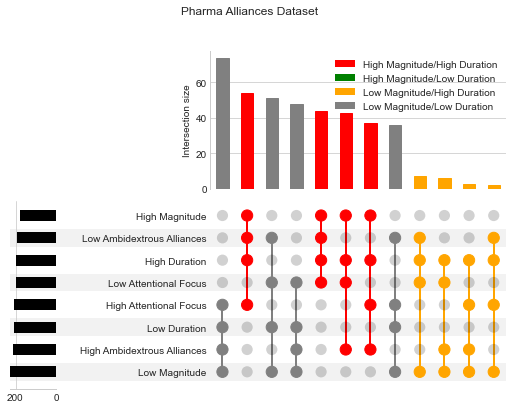

In [107]:
from matplotlib import pyplot as plt
from upsetplot import generate_counts, UpSet
upset = UpSet(counts_df,sort_by='cardinality')
upset.style_subsets(present=['High Magnitude','High Duration'],facecolor='red',label="High Magnitude/High Duration")
upset.style_subsets(present=['High Magnitude','Low Duration'],facecolor='green',label="High Magnitude/Low Duration")
upset.style_subsets(present=['Low Magnitude','High Duration'],facecolor='orange',label="Low Magnitude/High Duration")
upset.style_subsets(present=['Low Magnitude','Low Duration'],facecolor='grey',label="Low Magnitude/Low Duration")
upset.plot()
plt.suptitle('Pharma Alliances Dataset')
plt.savefig('upset_plot.png')

# Preparing data for regression

https://data.library.virginia.edu/introduction-to-mediation-analysis/

In [97]:
XY = df[dv+iv+['Id','Year']]
XY = XY.dropna()
X = XY[iv+['Year']]
X = X.copy()
X0 = X.drop(['Attentional focus'],axis=1)

In [98]:
model0 = sm.OLS(XY['Ambidextrous alliances'],X0)
est_model0 = model0.fit(cov_type='hac-groupsum',cov_kwds={'time':XY.set_index('Year').index,'maxlags':15})
print(est_model0.summary())
model1 = sm.OLS(XY['Attentional focus'],X0)
est_model1 = model1.fit(cov_type='hac-groupsum',cov_kwds={'time':XY.set_index('Year').index,'maxlags':15})
print(est_model1.summary())
model2 = sm.OLS(XY['Ambidextrous alliances'],X)
est_model2 = model2.fit(cov_type='hac-groupsum',cov_kwds={'time':XY.set_index('Year').index,'maxlags':15})
print(est_model2.summary())

                                   OLS Regression Results                                  
Dep. Variable:     Ambidextrous alliances   R-squared (uncentered):                   0.347
Model:                                OLS   Adj. R-squared (uncentered):              0.325
Method:                     Least Squares   F-statistic:                              264.1
Date:                    Sat, 22 Jul 2023   Prob (F-statistic):                    5.07e-32
Time:                            21:44:05   Log-Likelihood:                          228.84
No. Observations:                     365   AIC:                                     -433.7
Df Residuals:                         353   BIC:                                     -386.9
Df Model:                              12                                                  
Covariance Type:             hac-groupsum                                                  
                                       coef    std err          z      P>|z|    

In [99]:
mediation1 = Mediation(model2,model1,'High magnitude and High duration','Attentional focus').fit(n_rep=1000)
print(mediation1.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)           -0.005943       -0.018006        0.002455    0.186
ACME (treated)           -0.005943       -0.018006        0.002455    0.186
ADE (control)            -0.029802       -0.085045        0.025895    0.268
ADE (treated)            -0.029802       -0.085045        0.025895    0.268
Total effect             -0.035746       -0.090167        0.021140    0.180
Prop. mediated (control)  0.130759       -0.705683        1.859057    0.302
Prop. mediated (treated)  0.130759       -0.705683        1.859057    0.302
ACME (average)           -0.005943       -0.018006        0.002455    0.186
ADE (average)            -0.029802       -0.085045        0.025895    0.268
Prop. mediated (average)  0.130759       -0.705683        1.859057    0.302


In [100]:
mediation2 = Mediation(model2,model1,'High magnitude and Low duration','Attentional focus').fit(n_rep=1000)
print(mediation2.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.000830       -0.009617        0.012372    0.870
ACME (treated)            0.000830       -0.009617        0.012372    0.870
ADE (control)            -0.010370       -0.072519        0.057051    0.744
ADE (treated)            -0.010370       -0.072519        0.057051    0.744
Total effect             -0.009540       -0.074246        0.058693    0.766
Prop. mediated (control)  0.023146       -1.667378        1.815741    0.896
Prop. mediated (treated)  0.023146       -1.667378        1.815741    0.896
ACME (average)            0.000830       -0.009617        0.012372    0.870
ADE (average)            -0.010370       -0.072519        0.057051    0.744
Prop. mediated (average)  0.023146       -1.667378        1.815741    0.896


In [101]:
mediation3 = Mediation(model2,model1,'Low magnitude and High duration','Attentional focus').fit(n_rep=1000)
print(mediation3.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)           -0.017843       -0.039780       -0.002114    0.018
ACME (treated)           -0.017843       -0.039780       -0.002114    0.018
ADE (control)            -0.013473       -0.110561        0.087764    0.770
ADE (treated)            -0.013473       -0.110561        0.087764    0.770
Total effect             -0.031316       -0.130509        0.070352    0.498
Prop. mediated (control)  0.266162       -4.854951        4.628832    0.504
Prop. mediated (treated)  0.266162       -4.854951        4.628832    0.504
ACME (average)           -0.017843       -0.039780       -0.002114    0.018
ADE (average)            -0.013473       -0.110561        0.087764    0.770
Prop. mediated (average)  0.266162       -4.854951        4.628832    0.504


In [102]:
mediation4 = Mediation(model2,model1,'Low magnitude and Low duration','Attentional focus').fit(n_rep=1000)
print(mediation4.summary())

                          Estimate  Lower CI bound  Upper CI bound  P-value
ACME (control)            0.005822       -0.003149        0.018783    0.240
ACME (treated)            0.005822       -0.003149        0.018783    0.240
ADE (control)            -0.016968       -0.074618        0.040495    0.586
ADE (treated)            -0.016968       -0.074618        0.040495    0.586
Total effect             -0.011146       -0.069962        0.049034    0.674
Prop. mediated (control) -0.056989       -3.128925        1.992844    0.826
Prop. mediated (treated) -0.056989       -3.128925        1.992844    0.826
ACME (average)            0.005822       -0.003149        0.018783    0.240
ADE (average)            -0.016968       -0.074618        0.040495    0.586
Prop. mediated (average) -0.056989       -3.128925        1.992844    0.826
